# ATTAINS DATA EXPLORATION
<i> Ryan Treves

Under the Clean Water Act (CWA) section 303(d), states and Tribes are required to monitor water bodies in their territory, and identify water bodies for which a water quality standard has not been met. To do this, they must conduct 'assessments' of water bodies based on whether that water body attains its water quality standard for a certain type of use (e.g., swimming, fishing). Water bodies are delineated into 'assessment units' for the purposes of organizing assessments. Based on the results of the assessment, an assessment unit is assigned an Integrated Reporting (IR) category from 1-5 based on the degree of impairment of the water body. An IR category 5 determination means that a TMDL should be developed for that assessment unit, and the water is 'impaired'. (See https://drive.google.com/drive/u/0/folders/1tGpCSD-3mRBChTC1PZStt5bdRljTK1ck for more details on IR category determination).
 Every two years (reporting cycles are biennial), states must submit their list of impaired waters (including but not limited to all waters with an IR category 5 determination) as a part of their Integrated Report (IR) to the federal EPA under  sections 303(d), 305(b), and 314.

See https://www.epa.gov/wqs-tech/supplemental-module-listing-impaired-waters-and-developing-tmdls#tab-2  for more details.

### Questions:
- How many Assessment Units (AUs) exist nationwide?
- For many AUs do we have a HUC code match?
- How many use assessments nationwide, ever, have contributed to an IR5 category determination?
- How many unique assessment units have been assigned category IR5?
- Which states have had the most use assessments leading to IR5 determinations?
- Which states have had the highest rate of IR5 determinations per assessment unit?
- For what fraction of use assessments do we have an assessment date?
- What parameters have caused the most use non-attainment declarations?
- What parameters have caused the most assessment units to be categorized as IR5, irrespective of number of use non-attainment declarations?
- What uses have the highest rate of non-attainment?

Note: the dataset of AUs doesn't include Pennsylvania (see `ATTAINS_data_cleaning.ipynb` for an explanation)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen
import datetime as dt

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Assessment Units

In [49]:
# Load in national Assessment Unit (AU) data
AUs = pd.read_csv('Clean_AU_data/all_AUs_cleaned.csv')

/var/folders/1h/lmmglcgx2652108zjxqs36vr0000gq/T/ipykernel_7779/2797704080.py:2: DtypeWarning: Columns (5,11,16,17,18,19,20,21,22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  AUs = pd.read_csv('Clean_AU_data/all_AUs_cleaned.csv')


In [3]:
AUs.head()

,Unnamed: 0.1,Unnamed: 0,AUID,items.organizationIdentifier,items.organizationName,items.assessmentUnits.assessmentUnitIdentifier,items.assessmentUnits.assessmentUnitName,items.assessmentUnits.agencyCode,items.assessmentUnits.statusIndicator,items.assessmentUnits.useClass,items.assessmentUnits.waterTypes.waterTypeCode,items.assessmentUnits.waterTypes.waterSizeNumber,items.assessmentUnits.waterTypes.unitsCode,HUC-8,items.organizationTypeText,HUC-12,count,items.assessmentUnits.locationDescriptionText,items.assessmentUnits.stateCode,items.assessmentUnits.waterTypes.sizeEstimationMethodCode,items.assessmentUnits.waterTypes.sizeSourceText,items.assessmentUnits.waterTypes.sizeSourceScaleText,items.assessmentUnits.monitoringStations.monitoringOrganizationIdentifier,items.assessmentUnits.monitoringStations.monitoringLocationIdentifier,items.assessmentUnits.monitoringStations.monitoringDataLinkText,items.assessmentUnits.locations.locationTypeCode,items.assessmentUnits.locations.locationText,HUC-10
0,0,0,WYGR140401040103_01,Wyoming,State,Lower Big Sandy River,From the confluence with Squaw Creek downstrea...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,2.1,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,WYNP101800020105_02,Wyoming,State,Muddy Creek,Entire watershed upstream of the confluence wi...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,44.5,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,WYBH100800140107_01,Wyoming,State,Dry Gulch,From the confluence with the Shoshone River to...,WY,"{\useClassCode\"":\""117\""","\""useClassName\"":\""CLASS 3B\""}""",STREAM,0.5,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,WYBH100800030108_02,Wyoming,State,Little Popo Agie River,From the confluence with the Popo Agie River u...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,11.1,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,WYGR140401040303 _01,Wyoming,State,Pacific Creek,Confluence with Jack Morrow Creek upstream to ...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,13.8,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many Assessment Units (AUs) exist nationwide?
Note: this estimate doesn't include Pennsylvania, which according to https://attains.epa.gov/attains-public/api/assessmentUnits?stateCode=PA&returnCountOnly=Y contains on the order of 200,000 AUs on its own.

In [4]:
len(AUs['AUID'].unique())

331553

### For many AUs do we have a HUC code match?

In [5]:
AUs[(~pd.isna(AUs['HUC-12'])) | (~pd.isna(AUs['HUC-10'])) | (~pd.isna(AUs['HUC-8']))].shape[0]

99534

Note - that fact that we don't have HUC code matches for every AU may not be as big an issue as it seems.

# Assessments
Source: `pull_IR5_assessments.R`

### How many use assessments nationwide, ever, have contributed to an IR5 category determination?
Here, a use assessment is uniquely identified by assessmentUnitIdentifier + useName + reportingCycleText + assessment_date

In [2]:
assessments = pd.read_csv('all_IR5_assessments.csv', dtype={'reportingCycleText': str}, parse_dates=['assessment_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
assessments.head()

/var/folders/1h/lmmglcgx2652108zjxqs36vr0000gq/T/ipykernel_7779/2328312251.py:1: DtypeWarning: Columns (3,8) have mixed types. Specify dtype option on import or set low_memory=False.
  assessments = pd.read_csv('all_IR5_assessments.csv', dtype={'reportingCycleText': str}, parse_dates=['assessment_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))


,Unnamed: 0.1,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,reportStatusCode,assessmentUnitIdentifier,trophicStatusCode,useName,useAttainmentCode,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
0,0,1,AL,21AWIC,State,2008,Historical,AL-Gulf-of-Mexico,NaN,Contact Recreation,F,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
1,1,2,AL,21AWIC,State,2008,Historical,AL-Gulf-of-Mexico,NaN,Fishing,N,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
2,2,3,AL,21AWIC,State,2008,Historical,AL-Gulf-of-Mexico,NaN,Propagation of Fish and Wildlife,F,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
3,3,4,AL,21AWIC,State,2008,Historical,AL-Gulf-of-Mexico,NaN,Shellfishing,N,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01
4,4,5,AL,21AWIC,State,2008,Historical,AL-Gulf-of-Mexico,NaN,Industrial and Agriculture Uses,F,N,Cause,MERCURY,2006.0,1998,2013.0,1998-04-01


In [3]:
# All states are required to submit their 303(d) lists by April 1st - hence the cycles can be assigned to April 1st
assessments['reportingCycleText'] = pd.to_datetime(assessments['reportingCycleText'] + '-04-01', errors='coerce')
def repair_date(x):
    if not pd.isna(x):
        return pd.to_datetime(str(int(x)) + '-04-01', errors='coerce')
    return(x)
assessments['cycle_scheduled_for_TMDL'] = assessments['cycle_scheduled_for_TMDL'].apply(lambda x: repair_date(x))

In [4]:
assessments.head()

,Unnamed: 0.1,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,reportStatusCode,assessmentUnitIdentifier,trophicStatusCode,useName,useAttainmentCode,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
0,0,1,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Contact Recreation,F,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
1,1,2,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Fishing,N,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
2,2,3,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Propagation of Fish and Wildlife,F,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
3,3,4,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Shellfishing,N,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
4,4,5,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Industrial and Agriculture Uses,F,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01


In [5]:
assessments_nonattainment = assessments[assessments['useAttainmentCode']=='N']
assessments_nonattainment.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date']).shape[0]

564221

### How many unique assessment units have been assigned category IR5?

In [6]:
len(assessments['assessmentUnitIdentifier'].unique())

126751

### Which states have had the most use assessments leading to IR5 determinations?

In [7]:
assessments_nonattainment.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date'])['state_code'].value_counts()

PA    226200
VA     27282
NH     22287
IN     19875
MI     15928
WV     14355
MN     14161
FL     12923
NC     12718
TN     12564
CA     11523
KY     11422
NJ     11141
OR     10842
OK      9592
MA      9164
ID      8943
WA      8330
KS      8263
OH      7425
MT      7320
SC      6850
TX      6672
WI      5559
IL      5378
CT      4145
CO      3816
PR      3722
AL      3661
LA      3538
IA      3255
NM      2908
HI      2620
UT      2518
GA      2511
RI      2347
NV      2293
SD      2190
NE      2003
MS      1787
VT      1761
ME      1665
AR      1619
MD      1419
DE      1395
MO      1237
VI      1183
AK       845
AZ       782
WY       750
NY       664
ND       629
GU       241
Name: state_code, dtype: int64

### Which states have had the highest rate of IR5 determinations per assessment unit?

In [8]:
# Get counts of assessment units in each state
AU_counts = {}
for state in assessments['state_code'].unique():
    response = urlopen('https://attains.epa.gov/attains-public/api/assessmentUnits?stateCode=' + state + '&returnCountOnly=Y')
    data = json.loads(response.read())['count']
    AU_counts[state] = data

In [9]:
rates = pd.DataFrame(assessments_nonattainment.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date'])['state_code'].value_counts())
rates = rates.reset_index().rename(columns = {'index':'state', 'state_code':'# IR5 use assessments'})
rates['AUs'] = rates['state'].apply(lambda x: AU_counts[x])
rates['IR5 use assessment rate'] = rates['# IR5 use assessments']/rates['AUs']

In [10]:
rates.sort_values(by='IR5 use assessment rate', ascending=False).iloc[0:10]

,state,# IR5 use assessments,AUs,IR5 use assessment rate
12,NJ,11141,958,11.629436
27,PR,3722,358,10.396648
46,VI,1183,177,6.683616
29,LA,3538,563,6.284192
20,MT,7320,1203,6.084788
37,SD,2190,400,5.475000
19,OH,7425,1723,4.309344
18,KS,8263,2421,3.413052
15,MA,9164,2764,3.315485
36,NV,2293,711,3.225035


### For what fraction of use assessments do we have an assessment date?

In [11]:
use_assessments_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'assessment_date'])
use_assessments_unique[~pd.isna(use_assessments_unique['assessment_date'])].shape[0]/use_assessments_unique.shape[0]

0.23523383234162104

### What parameters have caused the most use non-attainment declarations?

In [12]:
assessments[assessments['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

ESCHERICHIA COLI (E. COLI)          0.077221
PATHOGENS                           0.055360
DISSOLVED OXYGEN                    0.050509
POLYCHLORINATED BIPHENYLS (PCBS)    0.044071
PCBS IN FISH TISSUE                 0.044023
FECAL COLIFORM                      0.037691
SEDIMENTATION/SILTATION             0.035051
MERCURY IN FISH TISSUE              0.034144
SILTATION                           0.033814
MERCURY                             0.030667
Name: parameterName, dtype: float64

### What parameters have caused the most assessment units to be categorized as IR5, irrespective of number of use non-attainment declarations?

In [13]:
IR5_culprits_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'reportingCycleText', 'assessment_date', 'parameterName'])

IR5_culprits_unique[IR5_culprits_unique['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

PATHOGENS                           0.089820
ESCHERICHIA COLI (E. COLI)          0.075335
SILTATION                           0.072774
DISSOLVED OXYGEN                    0.045020
PCBS IN FISH TISSUE                 0.037314
MERCURY                             0.037013
FECAL COLIFORM                      0.035480
POLYCHLORINATED BIPHENYLS (PCBS)    0.034196
PH                                  0.032331
CAUSE UNKNOWN                       0.031551
Name: parameterName, dtype: float64

### What uses have the highest rate of non-attainment?

In [14]:
use_assessments_unique['useName'].value_counts(normalize=True).iloc[0:10]

Water Contact Sports            0.082313
Fish Consumption                0.059401
Fishing                         0.052269
Warm Water Fishes               0.049517
Cold Water Fishes               0.043985
Aquatic Life                    0.032166
Primary Contact Recreation      0.029205
Recreation                      0.027474
Trout Stocking                  0.024389
Secondary Contact Recreation    0.022256
Name: useName, dtype: float64

Let's look at an example of one AUID x use x parameter combination over time:

In [78]:
assessments[(assessments['assessmentUnitIdentifier']=='AL03140106-0302-202') &
            (assessments['useName']=='Contact Recreation') &
            (assessments['parameterName']=='AMMONIA, TOTAL')].sort_values(by='reportingCycleText').drop_duplicates()

,Unnamed: 0.1,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,reportStatusCode,assessmentUnitIdentifier,trophicStatusCode,useName,useAttainmentCode,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
89,89,90,AL,21AWIC,State,2008-04-01,Historical,AL03140106-0302-202,NaN,Contact Recreation,N,N,Cause,"AMMONIA, TOTAL",2006.0,2008,2010-04-01,2006-04-01
1656,1656,1657,AL,21AWIC,State,2010-04-01,Historical,AL03140106-0302-202,NaN,Contact Recreation,N,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015-04-01,2006-04-01
4036,4036,4037,AL,21AWIC,State,2012-04-01,Historical,AL03140106-0302-202,NaN,Contact Recreation,N,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015-04-01,2006-04-01
6444,6444,6445,AL,21AWIC,State,2014-04-01,Historical,AL03140106-0302-202,NaN,Contact Recreation,N,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2016-04-01,2006-04-01


Clearly, the fields `cycle_first_listed`, `cycleLastAssessedText`, and `assessment_date` are misleading.

# Actions
Source: `pull_actions.R`

In [15]:
all_actions = pd.read_csv('all_actions.csv', parse_dates=['completionDate', 'TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).drop_duplicates()
all_actions_permit_data = pd.read_csv('all_actions_permit_data.csv').drop('Unnamed: 0', axis=1).drop_duplicates()

/var/folders/1h/lmmglcgx2652108zjxqs36vr0000gq/T/ipykernel_7779/1988036257.py:1: DtypeWarning: Columns (4,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  all_actions = pd.read_csv('all_actions.csv', parse_dates=['completionDate', 'TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).drop_duplicates()


In [16]:
all_actions.head()

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate
0,21AWIC,State,AL,36562,TMDL,EPA Final Action,2009-09-23,AL03160205-0310-702,FECAL COLIFORM,Nonpoint source,1320000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
2,21AWIC,State,AL,36561,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-400,FECAL COLIFORM,Both,2010000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
4,21AWIC,State,AL,36556,TMDL,EPA Final Action,2009-09-23,AL03150202-0202-401,FECAL COLIFORM,Both,7290000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
6,21AWIC,State,AL,36559,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-300,FECAL COLIFORM,Both,1660000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
8,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21


In [44]:
len(all_actions)

249039

### How many unique TMDL actions do we have?

In [18]:
len(all_actions.drop_duplicates(subset='actionIdentifier'))

20009

### How many unique AUs are represented in the actions data?

In [19]:
len(all_actions.drop_duplicates(subset='assessmentUnitIdentifier'))

96171

### Which states have the most TMDL actions?

In [20]:
all_actions.drop_duplicates(subset='actionIdentifier')['state_code'].value_counts(normalize=True)

WV    0.268479
KS    0.101804
VA    0.088460
MD    0.042031
MT    0.028787
DE    0.028237
CO    0.022990
OK    0.021290
FL    0.020241
CA    0.019791
GA    0.019791
LA    0.019741
MS    0.018692
SD    0.018442
PA    0.018342
MN    0.017192
MA    0.016892
OH    0.016143
NJ    0.015193
NY    0.012294
TX    0.011045
NH    0.009996
NM    0.009896
UT    0.009696
WY    0.009146
IL    0.009046
MO    0.008996
IA    0.008396
CT    0.008146
ID    0.007747
NE    0.007397
TN    0.007047
AL    0.006597
ME    0.006597
SC    0.006147
WA    0.006047
ND    0.005947
MI    0.005747
RI    0.005647
AR    0.005348
VT    0.004798
IN    0.004698
WI    0.004148
NC    0.003748
HI    0.002999
AK    0.002799
KY    0.002599
AZ    0.001599
NV    0.001149
VI    0.000950
PR    0.000650
OR    0.000250
GU    0.000150
Name: state_code, dtype: float64

### Which states have the highest rate of TMDL actions per AU?

In [21]:
# TMDL_rates = pd.DataFrame(all_actions.drop_duplicates(
#     subset=['actionIdentifier'])['state_code'].value_counts())
# TMDL_rates = TMDL_rates.reset_index().rename(columns={'index': 'state', 'state_code': '# TMDLs'})
# TMDL_rates['AUs'] = TMDL_rates['state'].apply(lambda x: AU_counts[x])
# TMDL_rates['TMDL rate'] = TMDL_rates['# TMDLs'] / TMDL_rates['AUs']
# TMDL_rates.sort_values(by='TMDL rate', ascending=False).iloc[0:10]

### What is the temporal distribution of TMDLs?

Based on a document here: https://www.exchangenetwork.net/schema/ATTAINS/1/ATTAINS_DET_v1.0a.xlsx , `completionDate` refers to the planned TMDL date, and `TMDLDate` refers to the actual date the TMDL was approved by EPA.

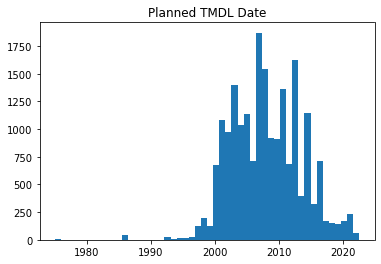

In [105]:
plt.title('Planned TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['completionDate'], bins=50);

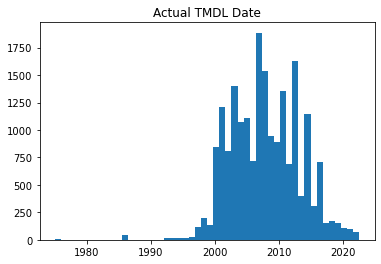

In [106]:
plt.title('Actual TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['TMDLDate'], bins=50);

Text(0.5, 1.0, 'Days between planned TMDL Date and actual TMDL Date')

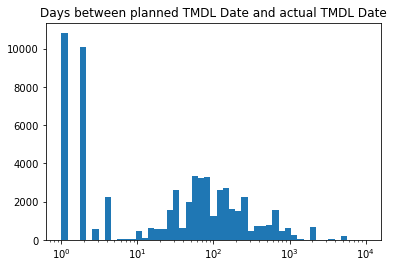

In [104]:
import numpy as np
delays = (all_actions.drop_duplicates(subset='assessmentUnitIdentifier')['TMDLDate'] -
          all_actions.drop_duplicates(subset='assessmentUnitIdentifier')['completionDate']) / dt.timedelta(
    days=1)
plt.xscale("log")
plt.hist(delays, bins=np.logspace(np.log10(1),np.log10(10000.0), 50))
plt.title('Days between planned TMDL Date and actual TMDL Date')

### Which pollutants most often lead to TMDLs?

In [24]:
all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])['pollutantName'].value_counts(normalize=True).iloc[0:10]

FECAL COLIFORM                  0.155362
IRON                            0.102766
ESCHERICHIA COLI (E. COLI)      0.070738
PHOSPHORUS, TOTAL               0.059801
SEDIMENT                        0.040726
PH                              0.037441
ALUMINUM                        0.036657
NITROGEN, TOTAL                 0.030498
TOTAL SUSPENDED SOLIDS (TSS)    0.027586
MANGANESE                       0.027474
Name: pollutantName, dtype: float64

### Which combinations of state x pollutant are most frequent across all TMDLS?

In [25]:
pd.DataFrame(all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])[['pollutantName', 'state_code']].value_counts(normalize=True).iloc[0:10])

0
pollutantName              state_code          
IRON                       WV          0.085558
FECAL COLIFORM             WV          0.050021
ALUMINUM                   WV          0.022061
PH                         WV          0.019411
ESCHERICHIA COLI (E. COLI) VA          0.017545
FECAL COLIFORM             VA          0.015902
                           KS          0.015454
MANGANESE                  WV          0.015118
DISSOLVED OXYGEN           KS          0.009705
SEDIMENT                   MT          0.009482

### For how many TMDL actions do we have one or more NPDES permit ID matches?

In [26]:
all_actions_permit_data.dropna().drop_duplicates('actionIdentifier').shape[0]

4069

### What is the distribution of these TMDLs across states?

In [111]:
all_actions_permit_data.dropna().drop_duplicates('actionIdentifier')['NPDESIdentifier'].apply(lambda x: x[0:2]).value_counts(normalize=True)

KS    0.167363
WV    0.109118
VA    0.060211
MS    0.046695
CA    0.041042
LA    0.039076
MN    0.036864
TX    0.036127
MD    0.033669
SD    0.032686
TN    0.028017
OK    0.026296
WY    0.023347
FL    0.022856
MO    0.022364
MT    0.021873
NE    0.021873
GA    0.018678
IL    0.017941
SC    0.016220
AL    0.014500
MI    0.012042
NM    0.011059
DE    0.010322
IA    0.010076
NC    0.009830
IN    0.009339
AR    0.009093
MA    0.007864
ID    0.007619
KY    0.007127
UT    0.006881
NJ    0.006636
AK    0.006636
RI    0.005898
CO    0.005652
N/    0.004424
ND    0.003686
PR    0.003195
CT    0.003195
NH    0.002703
AZ    0.002458
ME    0.001966
VT    0.001966
M-    0.001720
WA    0.001229
11    0.000983
HI    0.000983
No    0.000737
VI    0.000737
no    0.000737
OH    0.000737
OR    0.000492
WG    0.000492
GU    0.000492
2P    0.000492
00    0.000246
15    0.000246
S-    0.000246
 W    0.000246
IM    0.000246
#     0.000246
PA    0.000246
H1    0.000246
2I    0.000246
MG    0.000246
co    0.00

# TODO: Assessments & TMDLs

In [39]:
all_actions.iloc[0:100]

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate
0,21AWIC,State,AL,36562,TMDL,EPA Final Action,2009-09-23,AL03160205-0310-702,FECAL COLIFORM,Nonpoint source,1320000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
2,21AWIC,State,AL,36561,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-400,FECAL COLIFORM,Both,2010000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
4,21AWIC,State,AL,36556,TMDL,EPA Final Action,2009-09-23,AL03150202-0202-401,FECAL COLIFORM,Both,7290000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
6,21AWIC,State,AL,36559,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-300,FECAL COLIFORM,Both,1660000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
8,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21
9,21AWIC,State,AL,AL03160111_0303_102_Nutrients_2018,TMDL,EPA Final Action,2017-12-21,AL03160111-0305-102,"PHOSPHORUS, TOTAL",Both,NaN,NaN,NaN,2018-01-22
10,21AWIC,State,AL,AL03160111_0303_102_Nutrients_2018,TMDL,EPA Final Action,2017-12-21,AL03160111-0409-100,"PHOSPHORUS, TOTAL",Both,NaN,NaN,NaN,2018-01-22
11,21AWIC,State,AL,AL03160111_0303_102_Nutrients_2018,TMDL,EPA Final Action,2017-12-21,AL03160111-0404-102,"PHOSPHORUS, TOTAL",Both,NaN,NaN,NaN,2018-01-22
12,21AWIC,State,AL,AL03160111_0303_102_Nutrients_2018,TMDL,EPA Final Action,2017-12-21,AL03160111-0308-102,"PHOSPHORUS, TOTAL",Both,NaN,NaN,NaN,2018-01-22
13,21AWIC,State,AL,AL03160111_0303_102_Nutrients_2018,TMDL,EPA Final Action,2017-12-21,AL03160111-0413-112,"PHOSPHORUS, TOTAL",Both,NaN,NaN,NaN,2018-01-22


In [38]:
assessments.iloc[0:100]

,Unnamed: 0.1,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,reportStatusCode,assessmentUnitIdentifier,trophicStatusCode,useName,useAttainmentCode,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
0,0,1,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Contact Recreation,F,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
1,1,2,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Fishing,N,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
2,2,3,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Propagation of Fish and Wildlife,F,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
3,3,4,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Shellfishing,N,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
4,4,5,AL,21AWIC,State,2008-04-01,Historical,AL-Gulf-of-Mexico,NaN,Industrial and Agriculture Uses,F,N,Cause,MERCURY,2006.0,1998,2013-04-01,1998-04-01
5,5,6,AL,21AWIC,State,2008-04-01,Historical,AL03130003-0101-100,NaN,Contact Recreation,N,N,Cause,CAUSE UNKNOWN,2006.0,2006,2010-04-01,2006-04-01
6,6,7,AL,21AWIC,State,2008-04-01,Historical,AL03130003-0101-100,NaN,Fishing,N,N,Cause,CAUSE UNKNOWN,2006.0,2006,2010-04-01,2006-04-01
7,7,8,AL,21AWIC,State,2008-04-01,Historical,AL03130003-0101-100,NaN,Propagation of Fish and Wildlife,N,N,Cause,CAUSE UNKNOWN,2006.0,2006,2010-04-01,2006-04-01
8,8,9,AL,21AWIC,State,2008-04-01,Historical,AL03130003-0101-100,NaN,Industrial and Agriculture Uses,N,N,Cause,CAUSE UNKNOWN,2006.0,2006,2010-04-01,2006-04-01
9,9,10,AL,21AWIC,State,2008-04-01,Historical,AL03130003-1307-100,NaN,Contact Recreation,F,N,Cause,SEDIMENTATION/SILTATION,2006.0,1998,2009-04-01,1998-04-01


In [29]:
merged = all_actions.rename(columns={'pollutantName': 'parameterName'}).merge(assessments, on=['assessmentUnitIdentifier', 'organizationIdentifier', 'organizationTypeText', 'state_code', 'parameterName'], how='right')

In [36]:
len(merged.drop_duplicates(subset='actionIdentifier'))

4274

Which actions could we not merge with the assessments data?

In [68]:
AUID_list = list(assessments['assessmentUnitIdentifier'].unique())

In [82]:
all_actions[all_actions['assessmentUnitIdentifier'].apply(lambda x: x not in AUID_list)].head()

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate
8,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21
21,21AWIC,State,AL,39091,TMDL,EPA Final Action,2010-09-21,AL03160205-0300-201,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21
40,21AWIC,State,AL,31647,TMDL,EPA Final Action,2007-01-18,AL06030004-0102-100,FECAL COLIFORM,Nonpoint source,NaN,NaN,OCTOBER-MAY: GEOMETRIC MEAN OF 1000 COLONIES/...,2007-01-18
44,21AWIC,State,AL,31646,TMDL,EPA Final Action,2007-03-19,AL/06030002-200-01,PATHOGENS,Both,NaN,N,OCTOBER-MAY: GEOMETRIC MEAN OF 1000 COLONIES/...,2007-03-19
45,21AWIC,State,AL,31646,TMDL,EPA Final Action,2007-03-19,AL/06030002-200-01,FECAL COLIFORM,Both,NaN,N,NaN,2007-03-19


In [84]:
len(all_actions[all_actions['completionDate'] != all_actions['TMDLDate']])

194818

### How many AUs scheduled to receive a TMDL never received one?
Below, 'True' indicates that an AU never received a TMDL

In [31]:
merged.drop_duplicates(subset='assessmentUnitIdentifier')[['TMDLDate']].isna().value_counts(normalize=True)

TMDLDate
True        0.956158
False       0.043842
dtype: float64

### For those that did eventually receive a TMDL, what is the distribution of years between when the TMDL was scheduled, and when the TMDL was received?

In [80]:
delays = (merged.drop_duplicates(subset='assessmentUnitIdentifier')['TMDLDate']-merged.drop_duplicates(subset='assessmentUnitIdentifier')['cycle_scheduled_for_TMDL']) / dt.timedelta(days=365)

Text(0.5, 1.0, 'Years between TMDL schedule date and TMDL Date')

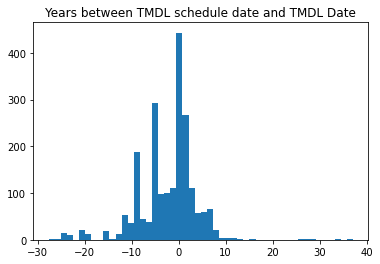

In [81]:
plt.hist(delays, bins=50)
plt.title('Years between TMDL schedule date and TMDL Date')